In [1]:
import json
from pprint import pprint
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uproot
from scipy.stats import bootstrap, norm

In [18]:
from gsfanalysis.pandas_import import uproot_to_pandas

In [19]:
input_dir = Path("../test_n1_1000/")

In [62]:
summary_short = uproot_to_pandas(uproot.open(str(input_dir / "root/tracksummary_gsf.root:tracksummary")))
len(summary_short)

993

In [63]:
input_dir_long = Path("../test_n100_1000/")

summary_long = uproot_to_pandas(uproot.open(str(input_dir_long / "root/tracksummary_gsf.root:tracksummary")))
len(summary_long)

99467

In [64]:
stat = np.std

In [65]:
def plot(dist, sample_mean, standard_error, confidence_interval=None, confidence_level=None):
    x = np.linspace(sample_mean + 4*standard_error, sample_mean - 4*standard_error)
    pdf = norm.pdf(x, loc=sample_mean, scale=res.standard_error)

    fig, ax = plt.subplots()
    ax.hist(dist, bins=25, density=True)
    ax.plot(x, pdf, label="µ={:.2f}, σ={:.4f}".format(sample_mean, standard_error), lw=5)
    ax.set_xlabel(stat.__name__)
    ax.set_ylabel('pdf')
    
    ymax = ax.get_ylim()[1]

    ax.vlines([sample_mean], ymin=0, ymax=ymax, color="tab:orange", lw=3, label="mean {:.3f}".format(sample_mean))
    ax.vlines([sample_mean + standard_error, sample_mean - standard_error], ymin=0, ymax=ymax, color="tab:orange", ls="--", label="standard error {:.3f}".format(standard_error))
    
    if not (confidence_interval is None or confidence_level is None):
        ax.vlines(confidence_interval, ymin=0, ymax=ymax, color="tab:orange", ls=":", label="confidence interval {:.1%}".format(confidence_level))
        
    ax.set_ylim(0, ax.get_ylim()[1]*1.3)

    ax.legend()

In [66]:
with open(input_dir / "config.json") as f:
    config = json.load(f)
    
#pprint(config)

In [67]:
conv_level = 0.95
res = bootstrap((summary_short["res_eQOP_fit"].to_numpy(),), stat, confidence_level=conv_level)
res.standard_error, res.confidence_interval

(0.018136967,
 ConfidenceInterval(low=0.07211206388884689, high=0.15037581586608223))

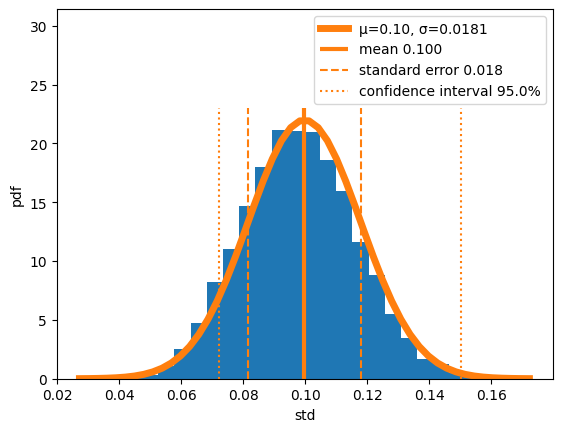

In [68]:
sample_mean = stat(summary_short["res_eQOP_fit"])

plot(res.bootstrap_distribution, sample_mean, res.standard_error, res.confidence_interval, conv_level)

In [69]:
event_means = []

for event_nr in range(max(summary_long["event_nr"])+1):
    df = summary_long[ summary_long["event_nr"] == event_nr ]
    event_means.append(stat(df["res_eQOP_fit"]))

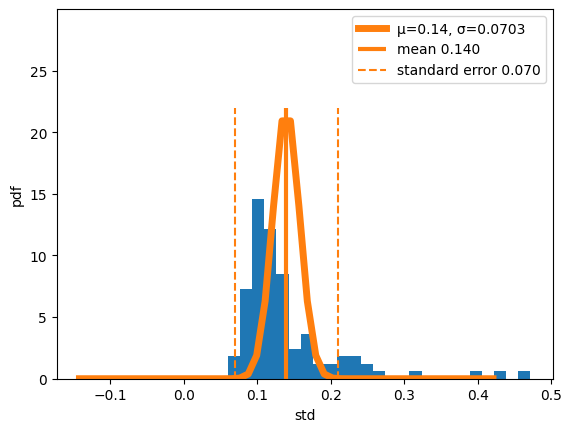

In [70]:
mu, sigma = np.mean(event_means), np.std(event_means)

plot(event_means, mu, sigma)

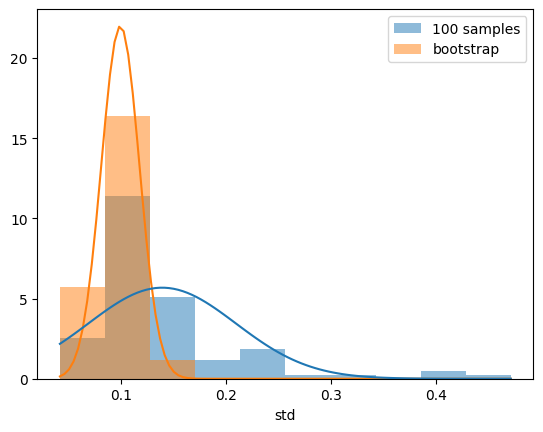

In [71]:
_, bins = np.histogram(np.concatenate([event_means, res.bootstrap_distribution]), density=True)

plt.hist(event_means, density=True, bins=bins, alpha=0.5, label="100 samples")
plt.hist(res.bootstrap_distribution, bins=bins, density=True, alpha=0.5, label="bootstrap")

x = np.linspace(bins[0], bins[-1], 100)
pdf1 = norm.pdf(x, loc=sample_mean, scale=res.standard_error)
pdf2 = norm.pdf(x, np.mean(event_means), np.std(event_means))

plt.plot(x, pdf1, c="tab:orange")
plt.plot(x, pdf2, c="tab:blue")

plt.xlabel(stat.__name__)

plt.legend()